## Library

In [153]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import copy # used to create a copy of a pytorch model
from IPython.display import clear_output
import time

## Prepare a set of random data for a binary classification problem

In [154]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 

X_test = X[900:]
y_test = y[900:]
X = X[:900]
y = y[:900]


print(f"X shape: {X_test.shape}")
print(f"y shape: {y_test.shape}")

X shape: (100, 2)
y shape: (100,)


## 3D Scatter Plot

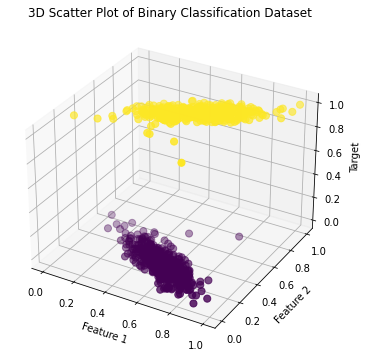

In [155]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

feature1 = X[:, 0]
feature2 = X[:, 1]
ax.scatter(feature1, feature2, y, c=y, cmap='viridis', s=50)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')

plt.title('3D Scatter Plot of Binary Classification Dataset')
plt.show()

## Model

In [156]:
class Model(nn.Module):
    def __init__(self, input_shape):
        super(Model, self).__init__()
        self.input_shape = input_shape
        self.layer1 = nn.Linear(input_shape[0], 8, bias=True)
        self.layer2 = nn.Linear(8, 16, bias=True)
        self.layer3 = nn.Linear(16, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.sigmoid(self.layer3(x))

        return x

## Node(Worker)

In [157]:
class Node():
    batch_size = 8

    def __init__(self, model, X, y):
        self.train_loader = self.preparData(X, y)
        self.criterion = nn.MSELoss()
        self.model = model

    def preparData(self, X, y):
        y = y.reshape((y.shape[0], 1))
        X = torch.tensor(X)
        y = torch.tensor(y)
        X = X.float()
        y = y.float()
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return data_loader
    
    def run(self, batch):  
        outputs = self.model(self.train_loader.dataset.tensors[0][batch*self.batch_size:batch*self.batch_size + self.batch_size])
        loss = self.criterion(outputs, self.train_loader.dataset.tensors[1][batch*self.batch_size:batch*self.batch_size + self.batch_size]) 
        loss.backward()

        return [param.grad.clone() for param in self.model.parameters()]

## Central Node

In [167]:
%clear

class Central():
    num_epochs = 20
    lr = 0.001
    batch_size = 8

    def __init__(self, X, y, x_test, y_test, num_workers=3):
        self.model = Model(input_shape=(2,))
        self.num_workers = num_workers
        self.dataset = self.devideData(X, y)
        self.workers = [Node(copy.deepcopy(self.model), self.dataset[0][i], self.dataset[1][i]) for i in range(num_workers)]
        self.criterion = nn.MSELoss()
        self.train_loader = self.preparData(X, y) 
        self.test_loader = self.preparData(x_test, y_test) 

    def preparData(self, X, y):
        y = y.reshape((y.shape[0], 1))
        X = torch.tensor(X)
        y = torch.tensor(y)
        X = X.float()
        y = y.float()
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
        return data_loader

    def devideData(self, X, y):
        l_x = []
        l_y = []
        for i in range(self.num_workers):
            l_x.append(X[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
            l_y.append(y[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
        return l_x, l_y
    
    def count_loss(self):
        outputs = self.model(self.test_loader.dataset.tensors[0]) 
        loss = self.criterion(outputs, self.test_loader.dataset.tensors[1])
        print(loss.item()) 
    
    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0
            for i in range(self.workers[0].train_loader.dataset.tensors[0].shape[0] // self.workers[0].batch_size): 
                grads = []
                for e, worker in enumerate(self.workers):
                    grads.append(worker.run(i))
                    print(f'Worker {e} was send its gradient on the batch number {i}!')
                    time.sleep(0.5)

                grad_agr= []
                for i in range(len(list(self.workers[0].model.parameters()))):
                    elem = 0
                    for grad in grads:
                        elem += grad[i]
                    grad_agr.append(elem)
                
                with torch.no_grad():
                    for p, g in zip(self.model.parameters(), grad_agr):
                        p -= self.lr * g
                print("Global model updated!")
                time.sleep(0.7)
                for worker in self.workers:
                    with torch.no_grad():
                        for param_src, param_dst in zip(self.model.parameters(), worker.model.parameters()):
                            param_dst.copy_(param_src)
                
                print("Local models updated!")
                time.sleep(0.7)
                clear_output(wait=True)
                

                outputs = self.model(self.train_loader.dataset.tensors[0][i*self.batch_size: i*self.batch_size + self.batch_size]) 
                loss = self.criterion(outputs, self.train_loader.dataset.tensors[1][i*self.batch_size: i*self.batch_size + self.batch_size]) 
                
                total_loss += loss.item()

            self.avg_loss = total_loss / (len(self.workers[0].train_loader) // self.num_workers)
            print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {self.avg_loss}")
            time.sleep(1)

## Initiate the setting

In [168]:
central = Central(X, y, X_test, y_test)

#### Count Loss before training

In [164]:
central.count_loss() 

0.24237972497940063


In [169]:
central.train()

Epoch 20/20, Loss: 5.604992508693032e-31


#### Count loss after training

In [166]:
central.count_loss()

0.05570816621184349
